In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import h5py
import numpy as np
from astropy.units import deg
from lenstools import GaussianNoiseGenerator, ConvergenceMap

/home/users/swmclau2/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


I want to study the global property of the clone dsets that I made. Specifically, 
* Power spectra
* Peak counts
* General pixel counts

I also want to see if these have any trends with cosmology, esp compared to the original maps. 

In [3]:
def count_peaks(im, size = 1):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(size, im.shape[0]-size):
        for j in range(size, im.shape[1]-size): # no peaks on the boundaries i declare
            block = im[i-size:i+size+1, j-size:j+size+1].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [4]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)

    return psd1D#/psd1D[0]

In [5]:
def image_bs(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.bispectrum(l)

    return psd1D#/psd1D[0]

In [6]:
def image_pc(image):
    image = (image-image.mean())/image.std()
    cmap = ConvergenceMap(image, angle=4*deg)
    #thresholds = np.arange(0.1, 0.3 ,0.001)
    thresholds = np.linspace(-5, 5, 200)
    nu,peaks = cmap.peakCount(thresholds, norm=False)
    return peaks#/psd1D[0]

In [7]:
def image_pdf(image):
    image = (image-image.mean())/image.std()
    cmap = ConvergenceMap(image, angle=4*deg)
    #thresholds = np.arange(0.1, 0.3 ,0.001)
    thresholds = np.linspace(-5, 5, 200)
    _,pdf = cmap.pdf(thresholds, norm=True)
    return pdf#/psd1D[0]

In [8]:
orig_fname = '/home/users/swmclau2/oak/Uatu/UatuLightconeTraining/UatuLightconeTraining.hdf5'
clone_fname = '/home/users/swmclau2/oak/Uatu/UatuLightconeTraining/UatuLightconeTrainingGuptaRobustified.hdf5'

In [9]:
def plot_pair(orig_fname, clone_fname, boxno, idx):
    fig = plt.figure(figsize=(12,6))
    with h5py.File(orig_fname, 'r') as f:
        mean, std = f.attrs['mean'], f.attrs['std']
        X1 = f[boxno]['X'][idx, :].squeeze()
        X1 = (X1-mean)/std
        
        
    with h5py.File(clone_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        X2 = f[boxno]['X'][idx, :].squeeze()
        #X2 = (X2-mean)/std
        
    plt.subplot(121)
    plt.imshow(X1)
    plt.subplot(122)
    plt.imshow(X2)
    plt.show()

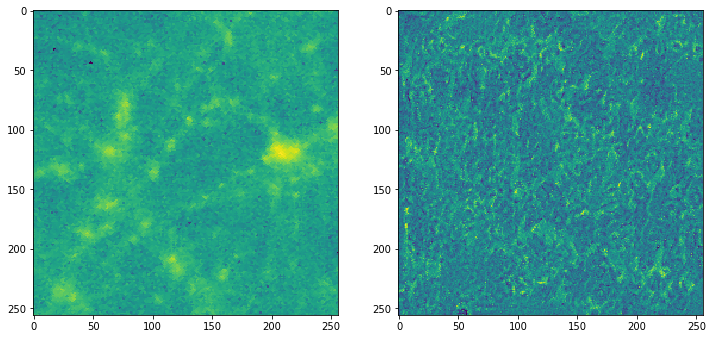

In [10]:
plot_pair(orig_fname, clone_fname, 'Box000', 24)

In [11]:
def compute_all_ps(fname, boxno, normalize= True):
    with h5py.File(fname, 'r') as f:
        X, Y = f[boxno]['X'][()].squeeze(), f[boxno]['Y'][0,:]
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            X = (X-mean)/std
            
        all_ps = np.zeros((289, 179))
        for i, x in enumerate(X):
            all_ps[i] = image_ps(x)
            
    return all_ps

In [12]:
def compute_all_bs(fname, boxno, normalize= True):
    with h5py.File(fname, 'r') as f:
        X, Y = f[boxno]['X'][()].squeeze(), f[boxno]['Y'][0,:]
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            X = (X-mean)/std
            
        all_ps = np.zeros((289, 179))
        for i, x in enumerate(X):
            all_ps[i] = image_bs(x)
            
    return all_ps

In [13]:
def compute_all_pc(fname, boxno, normalize= True):
    with h5py.File(fname, 'r') as f:
        X, Y = f[boxno]['X'][()].squeeze(), f[boxno]['Y'][0,:]
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            X = (X-mean)/std
            
        all_pc = np.zeros((289, 199))
        for i, x in enumerate(X):
            all_pc[i] = image_pc(x)
            
    return all_pc

note, should just make a generic function that applies some generic function of a cmap

In [14]:
def compute_all_pdf(fname, boxno, normalize= True):
    with h5py.File(fname, 'r') as f:
        X, Y = f[boxno]['X'][()].squeeze(), f[boxno]['Y'][0,:]
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            X = (X-mean)/std
            
        all_pc = np.zeros((289, 199))
        for i, x in enumerate(X):
            all_pc[i] = image_pdf(x)
            
    return all_pc

In [15]:
orig_ps = compute_all_ps(orig_fname, 'Box010')
clone_ps = compute_all_ps(clone_fname, 'Box010', normalize = False)

In [16]:
orig_pc = compute_all_pc(orig_fname, 'Box010')
clone_pc = compute_all_pc(clone_fname, 'Box010', normalize = False)

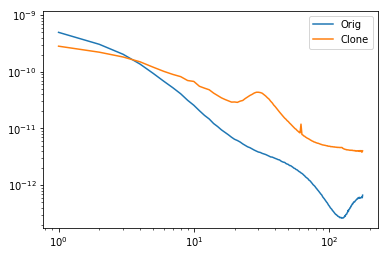

In [17]:
plt.plot(orig_ps.mean(axis=0), label = 'Orig')
plt.plot(clone_ps.mean(axis=0), label = 'Clone')
plt.legend(loc='best')
plt.loglog();

In [18]:
from time import time

In [19]:
l = np.linspace(128, 128*128, 180)
l2 = (l[1:]+l[:-1])/2.0
gen = GaussianNoiseGenerator(shape=(256,256),side_angle = 4 * deg)
grfs = np.zeros((289, 256, 256))
for i in xrange(289):
    gaussian_map = gen.fromConvPower(np.array([l2,orig_ps.mean(axis=0)]),seed = int(time()+i),bounds_error=False,fill_value=0.0)
    grfs[i] = gaussian_map.data

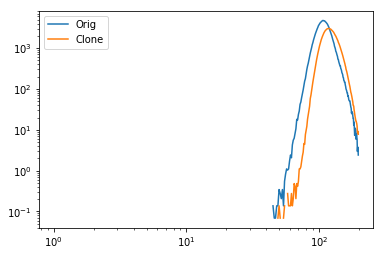

In [ ]:
plt.plot(orig_pc.mean(axis=0), label = 'Orig')
plt.plot(clone_pc.mean(axis=0), label = 'Clone')
plt.legend(loc='best')
plt.loglog();

In [ ]:
#all_orig_ps = np.zeros((20, 289, 179))
#all_clone_ps = np.zeros((20, 289, 179))
N = 200
all_orig_pc = np.zeros((N, 289, 199))
all_clone_pc = np.zeros((N, 289, 199))

all_orig_pdf = np.zeros((N, 289, 199))
all_clone_pdf = np.zeros((N, 289, 199))

all_ys = np.zeros((N, 2))
for boxno in xrange(N):
    print boxno
    boxname = 'Box%03d'%boxno
    with h5py.File(orig_fname, 'r') as f:
        y = f[boxname]['Y'][0,:]
        
    all_ys[boxno] = y.squeeze()
    #plot_pair(orig_fname, clone_fname, boxname, 128)
    #orig_ps = compute_all_ps(orig_fname, boxname)
    #clone_ps = compute_all_ps(clone_fname, boxname, normalize = False)
    
    #all_orig_ps[boxno] = orig_ps
    #all_clone_ps[boxno] = clone_ps
    
    orig_pc = compute_all_pc(orig_fname, boxname, normalize=False)
    clone_pc = compute_all_pc(clone_fname, boxname, normalize = False)
    
    all_orig_pc[boxno] = orig_pc
    all_clone_pc[boxno] = clone_pc
    
    orig_pdf = compute_all_pdf(orig_fname, boxname)
    clone_pdf = compute_all_pdf(clone_fname, boxname, normalize = False)
    
    all_orig_pdf[boxno] = orig_pdf
    all_clone_pdf[boxno] = clone_pdf
    
    #fig = plt.figure(figsize = (12,6))
    #plt.subplot(121)
    #plt.plot(orig_ps.mean(axis=0), label = 'Orig')
    #plt.plot(clone_ps.mean(axis=0), label = 'Clone')
    #plt.legend(loc='best')
    #plt.loglog();
    #plt.subplot(122)
    #plt.plot(orig_pc.mean(axis=0), label = 'Orig')
    #plt.plot(clone_pc.mean(axis=0), label = 'Clone')
    #plt.legend(loc='best')
    #plt.loglog();
    
    #plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


In [ ]:
#sorted_y_idxs = np.argsort(all_ys[:,0])
sorted_y_idxs = np.argsort(all_ys[:,1])

In [ ]:
cmap = sns.cubehelix_palette(N, start=2, rot=0, dark=0.1, light=.95)

In [ ]:
nu_ = np.linspace(-5, 5, 200)
#nu_ =  thresholds = np.arange(0.1, 0.3 ,0.001)

nu = (nu_[1:] + nu_[:-1])/2.0

In [ ]:
grf_pcs = np.zeros((289, 199))
grf_pdfs = np.zeros((289,199))
for i, im in enumerate(grfs):
    pc = image_pc(im)
    grf_pcs[i] = pc
    
    pdf = image_pdf(im)
    grf_pdfs[i] = pdf

In [ ]:
rand_images = np.random.randn(289, 256, 256)
rand_pcs = np.zeros((289, 199))
rand_pdfs = np.zeros((289,199))

for i, im in enumerate(rand_images):
    pc = image_pc(im)
    rand_pcs[i] = pc
    pdf = image_pdf(im)
    rand_pdfs[i] = pdf

In [ ]:
fig = plt.figure(figsize = (8,6))

for idx, c in enumerate(cmap):
    i = sorted_y_idxs[idx]
    plt.subplot(311)
    plt.title('Simulation Maps')
    plt.plot(nu, all_orig_pc[i].mean(axis = 0), c = c, label = r'$\Omega_m=%0.2f$'%all_ys[i,0], alpha = 0.7)
    plt.subplot(312)
    plt.title('Clone Maps')
    plt.plot(nu, all_clone_pc[i].mean(axis = 0), c = c, alpha = 0.7)
    
plt.subplot(313)
plt.title('GRF ')
plt.plot(nu, grf_pcs.mean(axis = 0))
plt.plot(nu, rand_pcs.mean(axis=0))

plt.legend(loc='best')
for i in xrange(3):
    plt.subplot(3,1,i+1)
    #plt.xlim([-5,5]);
plt.yscale('log');

In [ ]:
fig = plt.figure(figsize = (8,6))

for idx, c in enumerate(cmap):
    i = sorted_y_idxs[idx]
    #plt.subplot(311)
    plt.title('Simulation Maps v Clone Maps')
    plt.plot(nu, all_orig_pc[i].mean(axis = 0), c = c, label = r'$\Omega_m=%0.2f$'%all_ys[i,0], alpha = 0.7)
    #plt.subplot(312)
    #plt.title('Clone Maps')
    plt.plot(nu, all_clone_pc[i].mean(axis = 0), c = c, alpha = 0.7, ls = '--')
    
#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pcs.mean(axis = 0))

#plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-5,5]);
plt.yscale('log');

In [ ]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('Peak Counts')
plt.plot(nu, all_orig_pc.mean(axis = (0,1)), label = 'Sims')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, all_clone_pc.mean(axis = (0,1)), label = 'Clones')

#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pcs.mean(axis = 0), label = 'GRF')
#plt.plot(nu, rand_pcs.mean(axis = 0), label = 'Random')

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
plt.yscale('log');
plt.xlabel(r'Peak $\sigma$')

In [ ]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('Peak Counts')
plt.plot(nu, all_orig_pc.mean(axis = (0,1)), label = 'Sims')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, all_clone_pc.mean(axis = (0,1)), label = 'Clones')

#plt.subplot(313)
#plt.title('GRF')
plt.plot(nu, grf_pcs.mean(axis = 0), label = 'GRF')
plt.plot(nu, rand_pcs.mean(axis = 0), label = 'Random')

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
#plt.yscale('log');

K-s test of these 2 dists

In [ ]:
def ks_statistic(dist1, dist2):
    n,m = len(dist1), len(dist2)
    c = 1.358
    threshold = c*np.sqrt((n+m)*1.0/(n*m))
    d= np.max(np.abs(dist1-dist2))
    return d, d < threshold

In [ ]:
sim_pc = all_orig_pc.mean(axis = (0,1))
clone_pc = all_clone_pc.mean(axis = (0,1))

In [ ]:
sim_max_idx, clone_max_idx= np.argmax(sim_pc), np.argmax(clone_pc) 

In [ ]:
print np.abs(sim_max_idx- clone_max_idx)

In [ ]:
sim_max, clone_max = sim_pc[sim_max_idx], clone_pc[clone_max_idx]

In [ ]:
grf_pc = grf_pcs.mean(axis=0)
grf_pc/=np.max(grf_pc)
print np.abs(np.argmax(grf_pc) - sim_max_idx)

In [ ]:
rand_pc = rand_pcs.mean(axis=0)
rand_pc/=np.max(rand_pc)
print np.abs(np.argmax(rand_pc) - sim_max_idx)

In [ ]:
np.argmax(rand_pc[20:])

In [ ]:
len(rand_pc[20:-9]),len(nu[12:-17])

In [ ]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('Peak Counts')
plt.plot(nu[12:], all_orig_pc.mean(axis = (0,1))[:-12]/sim_max, label = 'Sims')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu[12:], all_clone_pc.mean(axis = (0,1))[12:]/clone_max, label = 'Clones')

#plt.subplot(313)
#plt.title('GRF')
plt.plot(nu[12:], grf_pc[11:-1], label = 'GRF', alpha = 0.4)
plt.plot(nu[12:-17], rand_pc[20:-9], label = 'Random', alpha = 0.4)

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
plt.yscale('log');
plt.xlabel(r'Peak $\sigma$ (Shifted)')

In [ ]:
ks_statistic(sim_pc[:-12]/sim_max, clone_pc[12:]/clone_max)

In [ ]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('PDFs')
plt.plot(nu, all_orig_pdf.mean(axis = (0,1)), label = 'Sims')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, all_clone_pdf.mean(axis = (0,1)), label = 'Clones')

#plt.subplot(313)
#plt.title('GRF')
plt.plot(nu, grf_pdfs.mean(axis = 0), label = 'GRF', alpha = 0.4)
plt.plot(nu, rand_pdfs.mean(axis = 0), label = 'Random', alpha = 0.4)

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
#plt.yscale('log');

In [ ]:
from scipy.stats import skewtest, skew

In [ ]:
skew(all_orig_pdf.mean(axis = (0,1)))

In [ ]:
skew(all_clone_pdf.mean(axis = (0,1)))

In [ ]:
skew(grf_pdfs.mean(axis=0))

In [ ]:
skew(rand_pdfs.mean(axis=0))

idea: cross correlate peak locations with embedding maps 